In [1]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

## algorithm

In [2]:
def ford_fulkerson(graph, source, sink, debug=None):
    flow, path = 0, True
    
    while path:
        # search for path with flow reserve
        path, reserve = depth_first_search(graph, source, sink)
        flow += reserve

        # increase flow along the path
        for v, u in zip(path, path[1:]):
            if graph.has_edge(v, u):
                graph[v][u]['flow'] += reserve
            else:
                graph[u][v]['flow'] -= reserve
        
        # show intermediate results
        if callable(debug):
            debug(graph, path, reserve, flow)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import available_backends, execute, register, get_backend, compile

from qiskit.tools import visualization


def oracle(circuit, f_in, f_out, aux, n, manual_index):
    for i in range(n):
        if(((manual_index >> i) & 1) == 0):
            circuit.x(f_in[n - i - 1])
    
    for i in range(n):
        circuit.cx(f_in[i], aux[i])

    circuit.ccx(aux[0], aux[1], aux[3])
    circuit.ccx(aux[2], aux[3], f_out[0])
    circuit.ccx(aux[0], aux[1], aux[3])
    
    for i in range(n):
        circuit.cx(f_in[i], aux[i])
    
    for i in range(n):
        if(((manual_index >> i) & 1) == 0):
            circuit.x(f_in[n - i - 1])

def n_controlled_Z(circuit, controls, target):
    if (len(controls) > 2):
        raise ValueError('The controlled Z with more than 2 ' +
                         'controls is not implemented')
    elif (len(controls) == 1):
        circuit.h(target)
        circuit.cx(controls[0], target)
        circuit.h(target)
    elif (len(controls) == 2):
        circuit.h(target)
        circuit.ccx(controls[0], controls[1], target)
        circuit.h(target)

def inversion_about_average(circuit, f_in, n):
    for j in range(n):
        circuit.h(f_in[j])
    for j in range(n):
        circuit.x(f_in[j])
    n_controlled_Z(circuit, [f_in[j] for j in range(n-1)], f_in[n-1])
    for j in range(n):
        circuit.x(f_in[j])
    for j in range(n):
        circuit.h(f_in[j])

def input_state(circuit, f_in, f_out, n):
    for j in range(n):
        circuit.h(f_in[j])
    circuit.x(f_out)
    circuit.h(f_out)

def get_predefine_index(arr):
    return arr.index(min(arr))

def Grover_search(arr):
    n = 3

    f_in = QuantumRegister(n)
    f_out = QuantumRegister(1)
    aux = QuantumRegister(n + 1)

    ans = ClassicalRegister(n)

    grover = QuantumCircuit()
    grover.add(f_in)
    grover.add(f_out)
    grover.add(aux)
    grover.add(ans)

    predefined_index = get_predefine_index(arr)

    input_state(grover, f_in, f_out, n)

    T = 2
    for t in range(T):
        oracle(grover, f_in, f_out, aux, n, predefined_index)
        inversion_about_average(grover, f_in, n)

    for j in range(n):
        grover.measure(f_in[j], ans[j])

    backend = Aer.get_backend('qasm_simulator')
    job = execute([grover], backend=backend, shots=1000)
    result = job.result()

    counts = result.get_counts(grover)
    inv = [(value, key) for key, value in counts.items()]
    outstr = str(max(inv)[1])
    ind = 0
    for i in range(len(outstr)):
        if outstr[i] == '1':
            ind = ind * 2 + 1
        else:
            ind = ind * 2
    print("ans ",ind+1)
    #print(arr[ind])
    visualization.plot_histogram(counts)
    return ind
    #return arr[ind]

#a = [1, 2, 0, 4, 5]
#Grover_search(a)

In [4]:

def depth_first_search(graph, source, sink):
    undirected = graph.to_undirected()
    explored = {source}
    print("Search for neighbour of ",source)
    grover_neighbour = Grover_search(adj_matrix[int(source)])
    #print(dict(undirected[source]))
    #print(graph[grover_neighbour])
    stack = [(source, 0, dict(undirected[source]))]
    #stack = [(source, 0, dict(grover_neighbour))]
    
    while stack:
        v, _, neighbours = stack[-1]
        if v == sink:
            break
        
        # search the next neighbour
        while neighbours:
            u, e = neighbours.popitem()
            if u not in explored:
                break
        else:
            stack.pop()
            continue
        
        # current flow and capacity
        in_direction = graph.has_edge(v, u)
        capacity = e['capacity']
        flow = e['flow']
        neighbours = dict(undirected[u])
        print("Search for neighbour of ",u)
        grover_neighbour = (Grover_search(adj_matrix[int(u)]))
        #print(dict(undirected[source]))
        print(grover_neighbour)
        #neighbours = dict(grover_search)

        # increase or redirect flow at the edge
        if in_direction and flow < capacity:
            stack.append((u, capacity - flow, neighbours))
            explored.add(u)
        elif not in_direction and flow:
            stack.append((u, flow, neighbours))
            explored.add(u)

    # (source, sink) path and its flow reserve
    reserve = min((f for _, f, _ in stack[1:]), default=0)
    path = [v for v, _, _ in stack]
    
    return path, reserve

## graph

In [5]:
graph = nx.DiGraph()
graph.add_nodes_from('123')
graph.add_edges_from([
    ('2', '1', {'capacity': 4, 'flow': 0}),
    ('1', '3', {'capacity': 5, 'flow': 0}),
])

adj_matrix = []
adj_matrix.append([1, 2, 3, 4])
adj_matrix.append([3, 2, 0, 1])
adj_matrix.append([0, 2, 3, 4])
adj_matrix.append([1, 2, 3, 4])

In [6]:
layout = {
    '2': [0, 1], '1': [1, 1], '3': [2, 1],
}

In [7]:
def draw_graph():
    plt.figure(figsize=(12, 4))
    plt.axis('off')

    nx.draw_networkx_nodes(graph, layout, node_color='steelblue', node_size=600)
    nx.draw_networkx_edges(graph, layout, edge_color='gray')
    nx.draw_networkx_labels(graph, layout, font_color='white')

    for u, v, e in graph.edges(data=True):
        label = '{}/{}'.format(e['flow'], e['capacity'])
        color = 'green' if e['flow'] < e['capacity'] else 'red'
        x = layout[u][0] * .6 + layout[v][0] * .4
        y = layout[u][1] * .6 + layout[v][1] * .4
        t = plt.text(x, y, label, size=16, color=color, 
                     horizontalalignment='center', verticalalignment='center')
        
    plt.show()

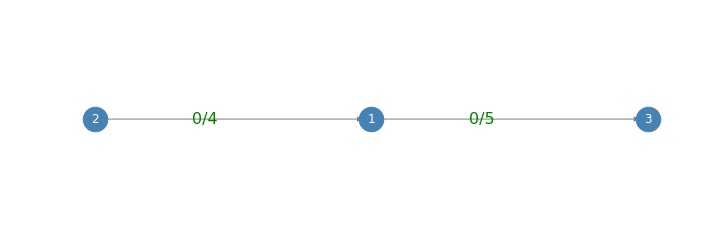

In [8]:
draw_graph()

## run

In [9]:
def flow_debug(graph, path, reserve, flow):
    print('flow increased by', reserve, 
          'at path', path,
          '; current flow', flow)
    draw_graph()

Search for neighbour of  2
ans  1


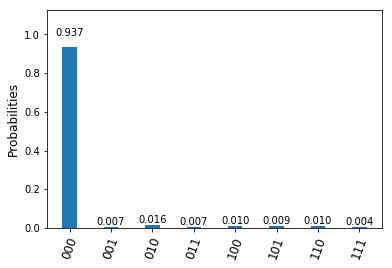

Search for neighbour of  1
ans  3


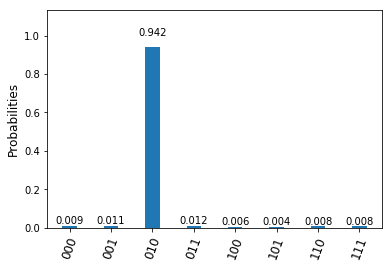

2
Search for neighbour of  3
ans  1


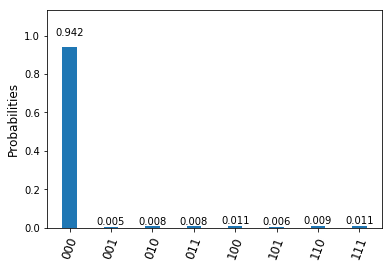

0
flow increased by 4 at path ['2', '1', '3'] ; current flow 4


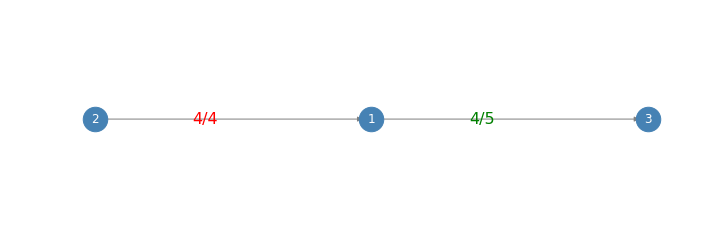

Search for neighbour of  2
ans  1


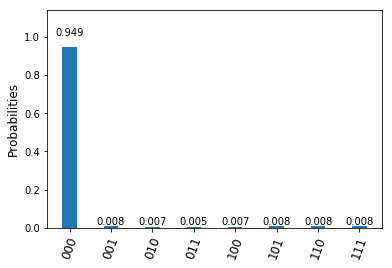

Search for neighbour of  1
ans  3


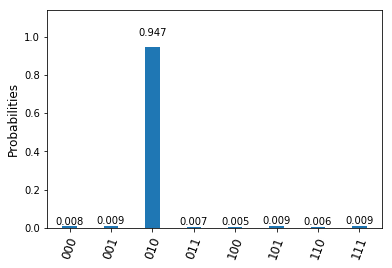

2
flow increased by 0 at path [] ; current flow 4


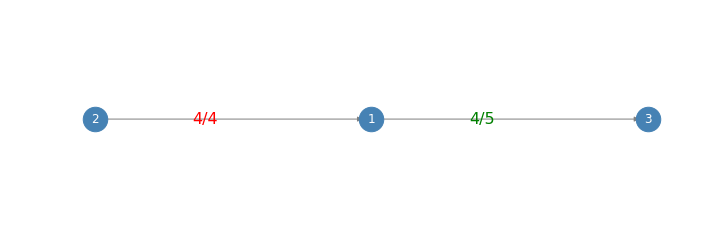

In [10]:
ford_fulkerson(graph, '2', '3', flow_debug)